# Lesson 5: Remote Data Science!

<b><u>Instructors:</u></b> Ishan Mishra, Phil Culliton


In this lesson, we're going to see what it's like to be a data scientist working with remote data through PySyft. We'll be making use of the same tabular COVID19 dataset that we cleaned, annotated, and uploaded in Lesson 3.

In [1]:
import syft as sy
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import os
import pandas as pd

%matplotlib inline

#### Log into domain

Here we log into your new node using a non-admin data scientist account. If you used a different email / password
combination to create the data scientist account, enter it here.

In [2]:
ds_domain = sy.login(
    email = "sheldon@caltech.edu",
    password = "bazinga",
    port = 8081
)

Connecting to localhost... done! 	 Logging into test_domain_1... done!


#### Check privacy budget

The privacy budget represents how much noise the data scientist can remove from a dataset when accessing it. Domains will set a privacy budget per data scientist. More (in this case, 100) can be requested using:

`ds_domain.request_budget(100)`

In [3]:
ds_domain.privacy_budget

100.0

#### List datasets on domain

There is only one dataset attached to this domain currently - let's take a look! The following command shows the data scientist:
1. The name and index of the available datasets.
2. A description, as entered by the data owner.
3. Any assets contained within the dataset - usually tensors or groups of tensors - and their names. In this case we just have string indices.
4. A unique ID - this can be used to access the dataset in addition to the index.

In [4]:
ds_domain.datasets

Idx,Name,Description,Assets,Id
[0],COVID19 Cases in 175 countries,Weekly data for an entire year,"[""Country 0""] -> int64[""Country 1""] -> int64[""Country 2""] -> int64...",b50d30e2-6b6f-465e-8dd5-8286140579b3
[1],COVID19 Cases in 175 countries,Weekly data for an entire year,"[""Country 6""] -> int64[""Country 8""] -> int64[""Country 13""] -> int64...",3deaa1fa-d1a4-4de4-b174-a56232e141e3
[2],COVID19 Cases in 175 countries,Weekly data for an entire year,"[""Country 163""] -> int64[""Country 170""] -> int64[""Country 0""] -> int64...",2c99b9da-7593-41a8-81bb-ed4f1c359ed2
[3],COVID19 Cases in 175 countries,Weekly data for an entire year,"[""Country 0""] -> int64[""Country 1""] -> int64[""Country 2""] -> int64...",5661f468-f9b5-4cbe-8531-2c5a6ecfd531


#### Select the COVID dataset

`covid_ds` is a pointer to the dataset above.

In [5]:
covid_ds = ds_domain.datasets[-1]

In [6]:
# covid_ds

#### Access the tensors in the dataset

1. Create `result` - a pointer to one of the selected dataset's tensors.

In [7]:
result = covid_ds["Country 0"]

2. `publish` uses the privacy budget approved by the data owner to access the data in a noised format that does not compromise the original dataset. `sigma` is the amount of privacy budget the data scientist plans to use.

In [8]:
published_result = result.publish(sigma=10)

3. We call `get()` to access the contents of the `published_result` pointer created above.

In [9]:
published_result.block_with_timeout(30).get()

FixedPrecisionTensor(child=[  989606 -1271316  -173907 -1287446  -550683   762915   -67253   -75452
  1081085   905149  1006072   365411  -769030   -58983   602912  1100445
   351143  -307910  -696208 -1170845  1077417   237121  -158996  -896585
  1362655    70886   440976    99656   151588   -10433  -330790   376455
 -1200348   834370  -309734  -747861   459355   164807  -171646   359894
  -861704   266916   703306   400929  -288101  -748443   124277   137735
   366384    47240   906716  -394538    77217])

#### Great! Now let's access a portion of the dataset in the same way.

Note that we are setting `sigma=10` for each object. In this case each object represents a different country's weekly COVID numbers - each country is a "data subject". We pause between each `.publish()` and `.get()` call to allow the server to receive the request and prepare the necessary data.

In [10]:
published_data = []

## "countries" 24 and 129 had the best / worst rates of infection
for i in [24, 129] + list(range(5)):
    result = covid_ds[f'Country {i}']
    published_result = result.publish(sigma=10)
    published_result.block_with_timeout(30)
    published_data.append(published_result.get())
    print(ds_domain.privacy_budget)
    
published_data = np.asarray(published_data)

100.0
92.23378337468827
92.23378337468827
92.23378337468827
92.23378337468827
92.23378337468827
92.23378337468827


In [11]:
len(published_data)

7

#### Load the dataset portion into a Pandas dataframe.

Let's plot the noisy data as well. In comparison to the data visualized in Lesson 3, it is impossible (thanks to differential privacy) to tell which country is which - but the machine learning properties of the data remain the same.

<AxesSubplot:>

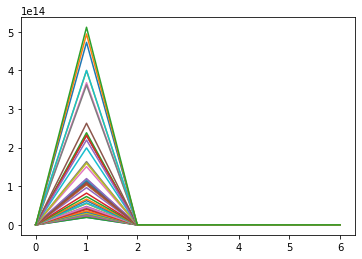

In [12]:
# TODO: remove this work around
deboxed = np.array([item.child for item in published_data.flatten()]).reshape(published_data.shape)
data_df = pd.DataFrame(deboxed)
data_df.plot(legend=False)

In [13]:
# data_df["total_cases_per_week"] = data_df.sum(1)
# data_df.plot(legend=False)

#### Let's focus on two countries

One had the best (lowest) infection rate and one had the worst (highest) infection rate.

<AxesSubplot:>

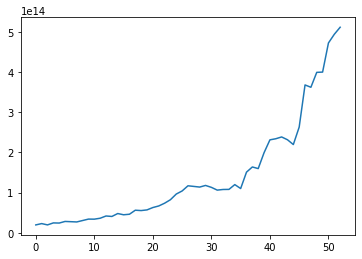

In [14]:
data_df.loc[1].plot()

<AxesSubplot:>

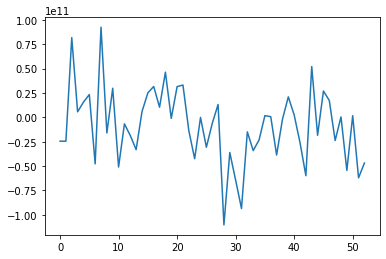

In [15]:
data_df.loc[0].plot()

#### And extrapolate out 3 more months

In [16]:
def plot_extrapolated_country(idx):
    x = list(range(53))
    y = data_df.loc[idx].values

    plt.plot(y)
    
    z = np.polyfit(x, y, 2)
    f = np.poly1d(z)

    new_points = range(12)
    new_y = []
    for x2 in new_points:
        new_y.append(f(53+x2))
        
    plt.plot(range(53, 65), new_y)

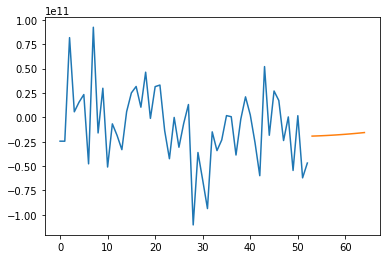

In [17]:
plot_extrapolated_country(0)

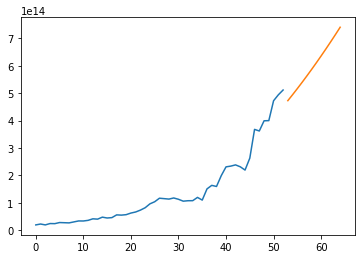

In [18]:
plot_extrapolated_country(1)

#### We've done some data science!

As you can see above, again, the data is obscured by noise, but the trends / modeling move in the expected direction for each set of data.

### Congratulations!

We've done data science work with a dataset on your node - a dataset that's protected by privacy enhancing technologies!